In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


class LinearRegressionScratch(d2l.Module):  # @save
  """The linear regression model implemented from scratch."""

  def __init__(self, num_inputs, lr, sigma=0.01, is_plot=True):
    """
    初始化线性回归模型的参数。

    Args:
    - num_inputs: 输入特征的数量。
    - lr: 学习率。
    - sigma: 权重初始化的标准差
    - is_plot: 是否绘制训练和验证损失图
    """
    super().__init__()
    self.save_hyperparameters()
    self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
    self.b = torch.zeros(1, requires_grad=True)

  def forward(self, X):
    """
    线性回归模型的前向传播。

    Args:
    - X: 输入特征矩阵。

    Returns:
    - y_hat: 预测值。
    """
    return torch.matmul(X, self.w) + self.b

  def loss(self, y_hat, y):
    """
    计算均方误差损失。

    Args:
    - y_hat: 预测值。
    - y: 真实值。

    Returns:
    - l: 损失值。
    """
    l = 0.5 * ((y_hat - y) ** 2)
    return l.mean()

  def configure_optimizers(self):
    """
    配置优化器。

    Returns:
    - optimizer: SGD优化器实例。
    """
    return SGD([self.w, self.b], self.lr)

  def training_step(self, batch):
    """
    单次训练步骤。

    Args:
    - batch: 一批训练数据。

    Returns:
    - l: 训练损失值。
    """

    # 在 Python 中，* 号用于解包（unpacking）可迭代对象。具体来说，*batch[:-1] 的作用是将 batch 列表中除最后一个元素外的所有元素解包为单独的参数，然后传递给函数。
    #
    # 详细解释
    # 假设 batch 是一个列表 [x1, x2, x3, y]，那么：
    #
    # batch[:-1] 会得到 [x1, x2, x3]。
    # *batch[:-1] 会将 [x1, x2, x3] 解包为 x1, x2, x3。
    # 因此，self(*batch[:-1]) 实际上等价于 self(x1, x2, x3)。
    l = self.loss(self(*batch[:-1]), batch[-1])
    if self.is_plot:
      self.plot("loss", l, train=True)
    return l

  def validation_step(self, batch):
    """
    单次验证步骤。

    Args:
    - batch: 一批验证数据。

    Returns:
    - l: 验证损失值。
    """
    l = self.loss(self(*batch[:-1]), batch[-1])
    if self.is_plot:
      self.plot("loss", l, train=False)


class SGD(d2l.HyperParameters):  # @save
  """Minibatch stochastic gradient descent."""

  def __init__(self, params, lr):
    """
    初始化SGD优化器。

    Args:
    - params: 需要优化的参数列表。
    - lr: 学习率。
    """
    self.save_hyperparameters()

  def step(self):
    """执行一次参数更新。"""
    for param in self.params:
      param -= self.lr * param.grad

  def zero_grad(self):
    """清零参数梯度。"""
    for param in self.params:
      if param.grad is not None:
        param.grad.zero_()

# 3.4.6. Exercises


##### 1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we initialized the parameters with variance $1000$ rather than $0.01$?

**如果我们将权重初始化为零，会发生什么？算法还会有效吗？如果我们将参数的方差初始化为 $1000$ 而不是 $0.01$ 呢？**


答：

算法仍然有效。因为这里的损失函数是凸的，并且只有一个最小值，所以权重的初始化方式并不重要。对于更复杂的网络，问题将会出现：输出将与输入无关，因此权重在开始时的移动方向无法从输入中学习到。（我的理解）


error in estimating w: tensor([ 0.1248, -0.1481])
error in estimating b: tensor([0.2113])


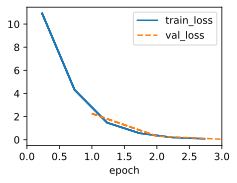

In [2]:
# 初始化线性回归模型，参数包括维度、学习率和正则化参数
model = LinearRegressionScratch(2, lr=0.03, sigma=0.0)

# 生成合成数据集，用于模型训练
# 这里指定了权重w和偏差b的真实值，以便后续比较模型估计的参数与真实值的误差
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

# 初始化训练器，设置最大训练轮数
trainer = d2l.Trainer(max_epochs=3)

# 开始模型训练过程
trainer.fit(model, data)

# 评估模型参数估计的误差
with torch.no_grad():
  # 计算并打印权重w的估计误差
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  # 计算并打印偏差b的估计误差
  print(f"error in estimating b: {data.b - model.b}")

有很多答案，比如 [链接](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)


error in estimating w: tensor([ 30.7578, -18.0260])
error in estimating b: tensor([5.2941])


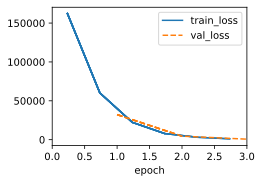

In [3]:
model = LinearRegressionScratch(2, lr=0.03, sigma=1000)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"error in estimating b: {data.b - model.b}")

估计误差将会非常大。如果我将 max_epochs 改为 10：


error in estimating w: tensor([0.0549, 0.0076])
error in estimating b: tensor([-0.0038])


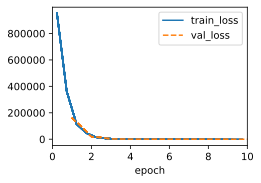

In [4]:
model = LinearRegressionScratch(2, lr=0.03, sigma=1000)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"error in estimating b: {data.b - model.b}")

错误会小得多。这是因为当初始参数离最优解太远时，我们需要迭代更多次才能得到一个好的估计。


##### 2. Assume that you are [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up with a model for resistance that relates voltage and current. Can you use automatic differentiation to learn the parameters of your model?

The model can be defined as:
$$U = R * I + \epsilon$$
After getting a number of $(U_i,I_i)$, we can estimate $R$ by linear regression. Suppose the actual value of $R$ is 5.

**假设你是乔治·西蒙·欧姆，试图提出一个与电压和电流相关的电阻模型。你能使用自动微分来学习模型的参数吗？**

模型可以定义为：
$$U = R * I + \epsilon$$

在获得多个 $(U_i,I_i)$ 后，我们可以通过线性回归估计 $R$。假设 $R$ 的实际值为 5。


error in estimating b: tensor([0.0423])


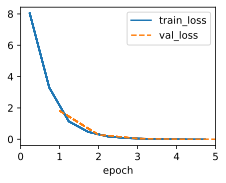

In [5]:
class ohmModel(d2l.Module):  # @save
  def __init__(self, lr):
    """
    初始化欧姆模型。
    参数:
    - lr: 学习率，用于优化器。
    """
    super().__init__()
    self.save_hyperparameters()  # 保存超参数
    self.w = torch.zeros(1, requires_grad=True)  # 初始化权重参数w

  def forward(self, X):
    return self.w * X

  def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2  # 计算损失
    return l.mean()

  def configure_optimizers(self):
    return SGD([self.w], self.lr)


# 创建欧姆模型实例，设置学习率为0.03
model = ohmModel(lr=0.03)
# 创建合成数据集，真实权重w为5.0，偏差b为0
data = d2l.SyntheticRegressionData(w=torch.tensor([5.0]), b=0)
# 创建训练器，设置最大训练轮数为5
trainer = d2l.Trainer(max_epochs=5)
# 训练模型
trainer.fit(model, data)

# 使用torch.no_grad()上下文管理器，禁用梯度计算
with torch.no_grad():
  # 打印权重参数的估计误差
  print(f"error in estimating b: {data.w - model.w}")

##### 3. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's constant, and $k$ is the Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral density curve to Planck's law.

**你能使用 [普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law) 通过光谱能量密度来确定物体的温度吗？作为参考，从黑体辐射出的光谱密度 $B$ 为 $$B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$$ 。这里 $\lambda$ 是波长，$T$ 是温度，$c$ 是光速，$h$ 是普朗克常数，$k$ 是玻尔兹曼常数。你测量了不同波长 $\lambda$ 的能量，现在需要将光谱密度曲线拟合到普朗克定律。**


tensor([4998.0522], requires_grad=True)

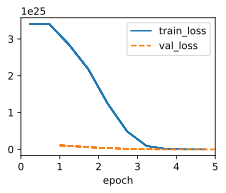

In [6]:
def f(t, x):
  """
  计算普朗克黑体辐射公式的结果，其中 t 是温度， x 是波长。
  """
  c = 299792458  # 光速（米）
  h = 6.6260701e-34  # 普朗克常数
  k = 1.380649e-23  # 玻尔兹曼常数
  beta = h * c / (k * x)
  alpha = 2 * h * c**2 / x**5
  return alpha / (torch.exp(beta / t) - 1)


class SyntheticPlankData(d2l.DataModule):
  def __init__(self, T, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
    super().__init__()
    self.save_hyperparameters()
    n = num_train + num_val
    # 生成波长数据
    self.X = torch.arange(300, n) * 1e-9
    noise = torch.randn(n - 300) * noise
    # 对应的辐射强度数据
    self.y = f(T, self.X) + noise

  def get_tensorloader(self, tensor, train, indices=slice(0, None)):
    tensor = tuple(a[indices] for a in tensor)
    dataset = torch.utils.data.TensorDataset(*tensor)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)


class PlankModel(d2l.Module):
  def __init__(self, T, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.T = torch.Tensor([T])
    self.T.requires_grad = True

  def forward(self, X):
    return f(self.T, X)

  def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

  def configure_optimizers(self):
    return d2l.SGD([self.T], self.lr)


data = SyntheticPlankData(5000)
model = PlankModel(T=3000, lr=1e-21)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
model.T

##### 4. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would you fix them?

**如果您想计算损失的二阶导数，可能会遇到什么问题？您将如何解决这些问题？**


答：(uncertain)

我们需要使用 `retain_graph=True` 来保留二阶导数的图形。


In [7]:
import torch

x = torch.tensor([1.0, 2.0], requires_grad=True)
print(x)
y = x**3

dy = torch.autograd.grad(
  y, x, grad_outputs=torch.ones(x.shape), retain_graph=True, create_graph=True
)

print(dy)
dy2 = torch.autograd.grad(dy, x, grad_outputs=torch.ones(x.shape))

print(dy2)

tensor([1., 2.], requires_grad=True)
(tensor([ 3., 12.], grad_fn=<MulBackward0>),)
(tensor([ 6., 12.]),)


对于复杂网络，计算二阶导数将消耗更多的时间和存储！


##### 5. Why is the `reshape` method needed in the `loss` function?

**为什么在 `loss` 函数中需要 `reshape` 方法？**


答：如果维度不匹配，使用 reshape 方法调整预测值或真实值的维度。


##### 6. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the error by increasing the number of epochs of training?

**实验使用不同的学习率来找出损失函数值下降的速度。通过增加训练的轮数，您能否减少误差？**


答：当学习率过大时，我们无法通过增加训练轮数来减少误差。因为参数以较大的步长更新，导致其跳过最优解。对于合适的学习率，我们可以将误差降低到较低水平。

尝试 LR = 0.03, 0.3, 3


error in estimating w: tensor([ 0.1048, -0.2496])
error in estimating b: tensor([0.2204])


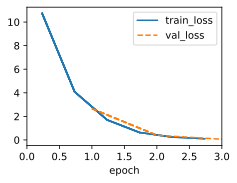

In [8]:
model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"error in estimating b: {data.b - model.b}")

error in estimating w: tensor([-0.0005,  0.0008])
error in estimating b: tensor([0.0005])


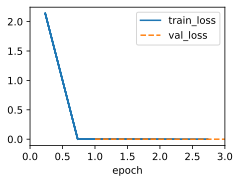

In [9]:
model = LinearRegressionScratch(2, lr=0.3, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"error in estimating b: {data.b - model.b}")

error in estimating w: tensor([ 1.0719e+31, -4.2718e+30])
error in estimating b: tensor([6.4377e+30])


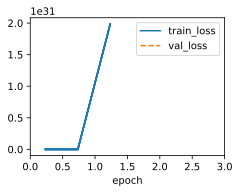

In [10]:
model = LinearRegressionScratch(2, lr=3, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"error in estimating b: {data.b - model.b}")

error in estimating w: tensor([nan, nan])
error in estimating b: tensor([nan])


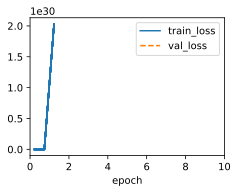

In [11]:
model = LinearRegressionScratch(2, lr=3, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"error in estimating b: {data.b - model.b}")

##### 7. If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?

**如果示例的数量无法被批量大小整除，那么在一个周期结束时 `data_iter` 会发生什么？**


答：`torch.utils.data.DataLoader` 有参数 `drop_last`。默认设置为 `False`，因此保留最后一批。由于我们在这里使用了 `1000` 个示例并将批量大小设置为 `32`，最后一批有 `8` 个示例。程序打印 `8` 三次，因为我们训练了 `3` 个周期。


In [12]:
class Trainer2(d2l.Trainer):  # @save
  def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
      if batch[0].size()[0] != 32:  # print the number of examples when it is not equal to 32
        print(batch[0].size()[0])
      loss = self.model.training_step(self.prepare_batch(batch))
      self.optim.zero_grad()
      with torch.no_grad():
        loss.backward()
        if self.gradient_clip_val > 0:  # To be discussed later
          self.clip_gradients(self.gradient_clip_val, self.model)
        self.optim.step()
      self.train_batch_idx += 1
    if self.val_dataloader is None:
      return
    self.model.eval()
    for batch in self.val_dataloader:
      with torch.no_grad():
        self.model.validation_step(self.prepare_batch(batch))
      self.val_batch_idx += 1


model = LinearRegressionScratch(2, lr=0.03, sigma=0.01, is_plot=False)
data = d2l.SyntheticRegressionData(
  w=torch.tensor([2, -3.4]), b=4.2, num_train=1000, num_val=1000, batch_size=32
)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)  # TODO 未打印输出？

##### 8. Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.

1. Check what happens for regular data.
2. Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5 = 10000$, of $\mathbf{y}$.
3. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss? Hint: how can you avoid really large gradient values?

**尝试实现不同的损失函数，例如绝对值损失 `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()` 。**

1. 检查常规数据会发生什么。
2. 检查如果主动扰动一些条目，例如 $y_5 = 10000$，是否会对 $\mathbf{y}$ 的行为产生差异。
3. 你能想到一个便宜的解决方案来结合平方损失和绝对值损失的最佳方面吗？提示：你如何避免非常大的梯度值？


答：

1. 更改为绝对值损失。


error in estimating w: tensor([-0.1599, -0.1305])
error in estimating b: tensor([-0.4800])


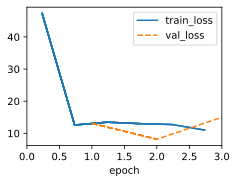

In [13]:
@d2l.add_to_class(LinearRegressionScratch)  # @save
def loss(self, y_hat, y):
  l = (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()
  return l.mean()


model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"error in estimating b: {data.b - model.b}")

估计值仍然接近真实值。然而，即使我增加训练轮数，损失也无法收敛到零。


error in estimating w: tensor([-0.3388,  0.0699])
error in estimating b: tensor([0.3000])


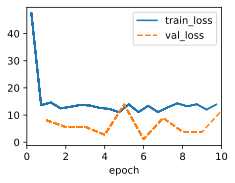

In [14]:
model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"error in estimating b: {data.b - model.b}")

当我降低学习率时，损失减少。


error in estimating w: tensor([ 0.0454, -0.0200])
error in estimating b: tensor([0.0800])


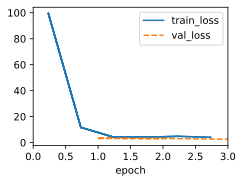

In [15]:
model = LinearRegressionScratch(2, lr=0.01, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

with torch.no_grad():
  print(f"error in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"error in estimating b: {data.b - model.b}")

似乎在使用绝对误差损失时，参数需要以较小的学习率进行更新。可能是因为损失曲线不平滑且不是凸的。


2. 使用平方损失时估计误差要大得多。这是因为平方损失对异常值更为敏感。

当设置为 y_5 = 10000 时


The absolute error loss in estimating w: tensor([-0.0132,  0.3768])
The absolute error loss in estimating b: tensor([0.2400])


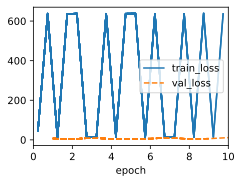

In [16]:
# 绝对误差损失：

model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data.y[4] = 10000
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
  print(f"The absolute error loss in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"The absolute error loss in estimating b: {data.b - model.b}")

The squared error loss in estimating w: tensor([-6.2577,  4.9603])
The squared error loss in estimating b: tensor([-7.8445])


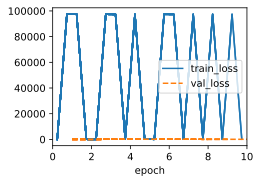

In [17]:
# 平方损失


@d2l.add_to_class(LinearRegressionScratch)  # @save
def loss(self, y_hat, y):
  l = (y_hat - y) ** 2 / 2
  return l.mean()


model = LinearRegressionScratch(2, lr=0.03, sigma=0.01)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
data.y[4] = 10000
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

with torch.no_grad():
  print(f"The squared error loss in estimating w: {data.w - model.w.reshape(data.w.shape)}")
  print(f"The squared error loss in estimating b: {data.b - model.b}")

3. 我们可以发现平方误差在其最小值的邻域内是强凸的，但对离群值敏感。我们可以使用 Huber 损失将它们结合起来：

![3_4_8](material/3_4_8.png)

该函数在小值的 $a$ 时是二次的，而在大值时是线性的。


##### 9. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?

**我们为什么需要重新洗牌数据集？你能设计一个案例，其中恶意构造的数据集会破坏优化算法吗？**


答：因为我们希望每一批数据能够反映整个数据集的特征。如果不是，我们可能会在一批中遇到相似示例的聚类，从而导致参数更新到错误的方向。数据集前半部分的噪声是正的，后半部分是负的。
